In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import EoN
import utils

# Setting up the network

In [3]:
G = nx.barabasi_albert_graph(10**5, 5)

In [4]:
avg_deg = np.mean(list(G.degree), axis=0)[1]
avg_deg

9.9995

The average degree of this network can be also calculated with $G'(1)$. 

In [5]:
EoN.get_PGFPrime(EoN.get_Pk(G))(1)

9.9995

The normalization constant for $G''(x)$ is $G''(1)$. 

In [14]:
rk_norm = EoN.get_PGFDPrime(EoN.get_Pk(G))(1)

The degree distribution of the network is 

In [15]:
pk = dict(sorted(EoN.get_Pk(G).items()))

Let's look at the degree distribution of this network. 

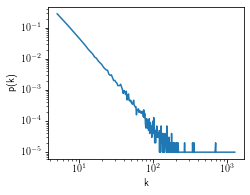

In [16]:
fig = utils.plot_pk(pk)

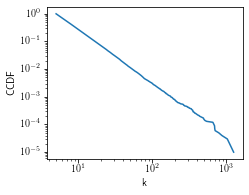

In [17]:
fig = utils.plot_ccdf_from_pk(pk)

How about the excess degree distribution and the excess-excess degree distribution? 

In [10]:
qk = dict((k-1, k * p / avg_deg) for k, p in pk.items())
rk = dict((k-2, k*(k-1)*p / rk_norm) for k, p in pk.items())

In [18]:
sum(qk.values()), sum(rk.values())

(1.0000000000000016, 1.0000000000000004)

Let's calculate their CCDF.

In [10]:
ccdfs = list(map(utils.ccdf_from_pk, [pk, qk, rk]))

Checking whether they are properly normalized or not.

In [11]:
print("{:0.3f}, {:0.3f}".format(sum(list(qk.values())), sum(list(rk.values()))) )

1.000, 1.000


If we plot the distribution described by $G_0, G_1, G_2$, we can see how each step emphasizes high degree nodes. 

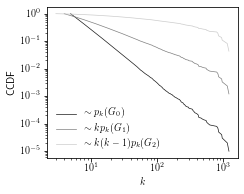

In [12]:
plot_kwargs_for_base_ccdfs = [
    {"label": r"$\sim p_k (G_0)$", "color": (0.1, 0.1, 0.1), 'linewidth': 0.7}, 
    {"label": r"$\sim k p_k (G_1)$", "color": (0.5, 0.5, 0.5), 'linewidth': 0.7}, 
    {"label": r"$\sim k(k-1) p_k (G_2)$", "color": (0.8, 0.8, 0.8), 'linewidth': 0.7}, 
]

fig = utils.loglog_plot(ccdfs, kwargs_list=plot_kwargs_for_base_ccdfs, xlabel=r"$k$", ylabel=r"CCDF")
plt.tight_layout()
plt.savefig('deg_dist.pdf')

# Let's run some simulations

In [13]:
params = {'tmax': 100,  
          'tau': 0.1,    # transmission rate (for edges)
          'gamma': 1,  # recovery rate (for nodes)
          'rho': 0.001,  # initial seed fraction
         }
print("Estimated R0: {:.2f}".format(
    EoN.estimate_R0(G, transmissibility = params['tau']/(params['tau']+params['gamma']))
))

Estimated R0: 3.06


In [14]:
sim_data = EoN.fast_SIR(G, return_full_data=True, **params)

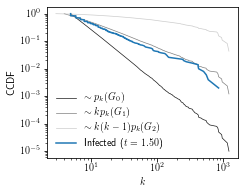

In [15]:
infected = utils.nodes_with_given_state_at_time(1.5, "I", sim_data, G.nodes())
infected_ccdf = utils.ccdf_from_data(list(dict(G.degree(infected)).values()))
fig = utils.loglog_plot(
    ccdfs + [infected_ccdf], 
    kwargs_list=plot_kwargs_for_base_ccdfs + [{'label': r"Infected ($t={:.2f}$)".format(1.5)}], 
    xlabel=r"$k$", ylabel=r"CCDF")
plt.tight_layout()
plt.savefig('deg_dist_infected.pdf')

We can make an animation!

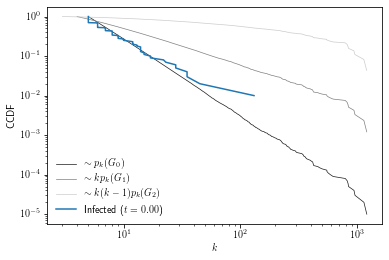

In [16]:
fig, ax = plt.subplots()

def update(frame):
    t = frame / 10.0
    infected = utils.nodes_with_given_state_at_time(t, "I", sim_data, G.nodes())
    infected_ccdf = utils.ccdf_from_data(list(dict(G.degree(infected)).values()))
    ax.clear()
    utils.loglog_plot(ccdfs + [infected_ccdf], 
        kwargs_list=plot_kwargs_for_base_ccdfs + [{'label': r"Infected ($t={:.2f}$)".format(t)}], 
        ax=ax, xlabel=r"$k$", ylabel=r"CCDF")

ani = FuncAnimation(fig, update, frames=np.linspace(0, 100), interval=400, repeat_delay=2000)
ani.save('deg_dist_infected.gif',writer='imagemagick') 

As shown in [this paper](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.92.178701), we can see that the degree distribution of the infected nodes closely follow $ k p_k $ at the beginning and then gradually converges to $p_k$. 

In [17]:
from IPython.display import HTML
HTML('<img src="deg_dist_infected.gif">')

Let's first check whether the degree distribution of the infected nodes at the early stage roughly follow the excess degree distribution. 

## Contact tracing 

We can then simulate the contact tracing. 

1. At time `t`, we sample currently infected nodes with probability `p_sample`.
2. For each node, we add their neighbors to a counter with probability `p_neighbor`. 
3. From the counter, we pull out the top N or anyone who appeared more than once. 

In reality, the actual parent is more likely to be sampled because the parent node is likely appear in the recent-past contact list. We can modify the tracing mechanism so that we sample the actual parent with `p_parent` and then others with `p_neighbor`. 

In [18]:
t=2
cnt = utils.trace_contacts(t, sim_data, G, p_sample=0.5, p_neighbor=0.5)
traced_1 = [x[0] for x in cnt.most_common(30)]
traced_2 = [x[0] for x in cnt.items() if x[1] > 1]

In [19]:
print(len(traced_1), len(traced_2))

30 488


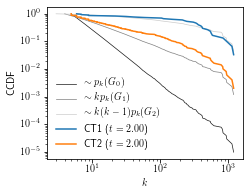

In [20]:
tr1_ccdf = utils.ccdf_from_data(list(dict(G.degree(traced_1)).values()))
tr2_ccdf = utils.ccdf_from_data(list(dict(G.degree(traced_2)).values()))


fig = utils.loglog_plot(ccdfs + [tr1_ccdf, tr2_ccdf], 
    kwargs_list=plot_kwargs_for_base_ccdfs + [{'label': r"CT1 ($t={:.2f}$)".format(t)}, 
                                             {'label': r"CT2 ($t={:.2f}$)".format(t)}],
                            xlabel=r"$k$", ylabel=r"CCDF")

Just randomly sampling the neighbors is not effective. But if we only look at the most frequently sampled contacts, then it is similar to $G_2$ ($\sim k(k-1)p_k$). In other words, it is better at sampling hubs than acquaintance sampling. 

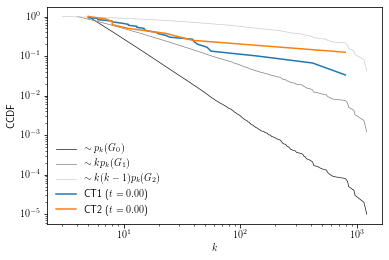

In [63]:
fig, ax = plt.subplots()

def update_trace_ani(frame, p_sample=0.5, p_neighbor=0.5):
    t = frame / 30.0
    
    cnt = utils.trace_contacts(t, sim_data, G, p_sample=p_sample, p_neighbor=p_neighbor)
    traced_1 = [x[0] for x in cnt.most_common(30)]
    traced_2 = [x[0] for x in cnt.items() if x[1] > 1]
    tr1_ccdf = utils.ccdf_from_data(list(dict(G.degree(traced_1)).values()))
    tr2_ccdf = utils.ccdf_from_data(list(dict(G.degree(traced_2)).values()))
    
    ax.clear()
    utils.loglog_plot(ccdfs + [tr1_ccdf, tr2_ccdf], 
        kwargs_list=plot_kwargs_for_base_ccdfs + [{'label': r"CT1 ($t={:.2f}$)".format(t)}, 
                                             {'label': r"CT2 ($t={:.2f}$)".format(t)}],
                            xlabel=r"$k$", ylabel=r"CCDF", ax=ax)

ani = FuncAnimation(fig, update_trace_ani, frames=np.linspace(0, 300), interval=150, repeat_delay=2000)
ani.save('deg_dist_traced.gif', dpi=150, writer='imagemagick') 

In [64]:
from IPython.display import HTML
HTML('<img src="deg_dist_traced.gif">')

Let's think about the case where we randomly sample infected nodes at $t$ and then perfectly identifies the parent (source) of the infection. 

In [24]:
T = sim_data.transmission_tree()

In [60]:
infected = utils.nodes_with_given_state_at_time(1.5, "I", sim_data, G.nodes())
infected_sampled = np.random.choice(infected, 50)
parents = []
for x in infected_sampled:
    if x in T:
        parent = list(T.predecessors(x))
        if parent:
            parents.append(parent[0])

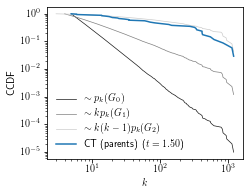

In [68]:
parents_ccdf = utils.ccdf_from_data(list(dict(G.degree(parents)).values()))
t = 1.5

fig = utils.loglog_plot(ccdfs + [parents_ccdf], 
    kwargs_list=plot_kwargs_for_base_ccdfs + [{'label': r"CT (parents) ($t={:.2f}$)".format(t)}],
                            xlabel=r"$k$", ylabel=r"CCDF")